### TODO
- Differencing Time Series, Reduce variance, remove seasonality?
- Compare with ARIMA, MLP, ConvNet, Facebook Prophet
- Automatic Hyperparameter optimization (Bayesian?)
- Find better ways to split training/test set

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"),flavor='html5lib')[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-25,8612.81,8682.01,8449.10,8495.78,4569880000,145882000000
1,2018-03-24,8901.95,8996.18,8665.70,8668.12,5664600000,150762000000
2,2018-03-23,8736.25,8879.62,8360.62,8879.62,5954120000,147941000000
3,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000
4,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000


In [3]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"),flavor='html5lib')[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-25,522.70,535.82,515.66,524.29,1151170000,51431600000
1,2018-03-24,542.57,545.38,526.08,526.44,1300010000,53375400000
2,2018-03-23,539.86,540.49,512.13,539.62,1596350000,53098100000
3,2018-03-22,562.10,577.57,523.09,539.70,1523460000,55273800000
4,2018-03-21,559.10,589.61,550.57,561.73,1781270000,54967300000


In [4]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [5]:

market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-03-25,8612.81,8682.01,8449.10,8495.78,4569880000,145882000000,522.70,535.82,515.66,524.29,1151170000,51431600000,-0.013588,0.003042
1,2018-03-24,8901.95,8996.18,8665.70,8668.12,5664600000,150762000000,542.57,545.38,526.08,526.44,1300010000,53375400000,-0.026267,-0.029729
2,2018-03-23,8736.25,8879.62,8360.62,8879.62,5954120000,147941000000,539.86,540.49,512.13,539.62,1596350000,53098100000,0.016411,-0.000445
3,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000,562.10,577.57,523.09,539.70,1523460000,55273800000,-0.023600,-0.039851
4,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000,559.10,589.61,550.57,561.73,1781270000,54967300000,-0.000917,0.004704


In [6]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [7]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
814,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
813,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
812,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
811,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
810,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [8]:
#Training / Test Set Split

In [9]:
split_date = '2017-06-01'
training_set, test_set = model_data[model_data["Date"]<split_date], model_data[model_data['Date']>= split_date]
training_set = training_set.drop('Date',1)
test_set = test_set.drop('Date',1)

In [10]:
training_set.head()

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
814,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
813,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
812,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
811,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
810,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [11]:
#Window settings for timeseries analysis
window_len=10
cols_train = training_set.columns
cols_test = training_set.columns
norm_cols = [coin+metric for coin in ['bt_','eth_'] for metric in ['Close','Volume']]
output_cols = [coin+metric for coin in ['bt_','eth_'] for metric in ['Close']]

cols_train_ex_norm  = list(filter(lambda x: x not in norm_cols,cols_train))
cols_test_ex_norm  = list(filter(lambda x: x not in norm_cols,cols_test))

In [12]:
#Create normalized windows: training

LSTM_training_inputs=[]
LSTM_training_outputs=[]
for i in range(len(training_set)-window_len):
    temp_window=training_set[i:(i+window_len)]
    temp_set_in = pd.concat([temp_window[cols_train_ex_norm],(temp_window[norm_cols]/temp_window[norm_cols].iloc[0] -1)],axis=1)
    LSTM_training_inputs.append(temp_set_in.fillna(0.0))

In [13]:
LSTM_training_outputs_bt = (training_set[output_cols[0]][window_len:].values/training_set[output_cols[0]][:-window_len].values)-1
LSTM_training_outputs_eth = (training_set[output_cols[1]][window_len:].values/training_set[output_cols[1]][:-window_len].values)-1

Prediction: Change from beginning of window period to value of day after window period

|awwwwwwww|p  input is |..|, predict change of price(p/a -1),

In [14]:
print(LSTM_training_inputs[0],len(LSTM_training_inputs))
print(LSTM_training_outputs_bt[0],len(LSTM_training_outputs_bt))

     bt_close_off_high  bt_volatility  eth_close_off_high  eth_volatility  \
814          -0.560641       0.020292           -0.418477        0.025040   
813           0.250597       0.009641            0.965898        0.034913   
812          -0.173865       0.020827           -0.317885        0.060792   
811          -0.474265       0.012649           -0.057657        0.047943   
810          -0.013333       0.010391            0.697930        0.025236   
809          -0.003623       0.012782           -0.214540        0.026263   
808          -0.951499       0.069045            0.681644        0.040587   
807           0.294196       0.032762           -0.806717        0.055274   
806           0.814194       0.017094           -0.411897        0.019021   
805          -0.919598       0.017758           -0.938235        0.025266   

     bt_Close  bt_Volume  eth_Close  eth_Volume  
814  0.000000   0.000000   0.000000    0.000000  
813 -0.002049  -0.170410  -0.011498    0.239937  
81

In [15]:
#Create normalized windows: training

LSTM_test_inputs=[]
LSTM_test_outputs=[]
for i in range(len(test_set)-window_len):
    temp_window=test_set[i:(i+window_len)]
    temp_set_in = pd.concat([temp_window[cols_test_ex_norm],(temp_window[norm_cols]/temp_window[norm_cols].iloc[0] -1)],axis=1)
    LSTM_test_inputs.append(temp_set_in.fillna(0.0))

In [16]:
LSTM_test_outputs_bt = (test_set[output_cols[0]][window_len:].values/test_set[output_cols[0]][:-window_len].values)-1
LSTM_test_outputs_eth = (test_set[output_cols[1]][window_len:].values/test_set[output_cols[1]][:-window_len].values)-1

In [17]:
print(LSTM_test_inputs[0],len(LSTM_test_inputs))
print(LSTM_test_outputs_bt[0],len(LSTM_test_outputs_bt))

     bt_close_off_high  bt_volatility  eth_close_off_high  eth_volatility  \
297          -0.493815       0.069946            0.286109        0.094157   
296          -1.000000       0.047932            0.145473        0.044222   
295          -0.159278       0.063496           -0.514504        0.029312   
294           0.111061       0.052339           -0.615588        0.117928   
293          -1.000000       0.070287           -0.685358        0.026176   
292          -0.115346       0.114860           -0.705854        0.083146   
291           0.625637       0.058835            0.241769        0.040226   
290          -0.865882       0.053060           -0.859903        0.032094   
289           0.468564       0.037789           -0.902903        0.080267   
288          -0.967912       0.072288           -0.631062        0.242013   

     bt_Close  bt_Volume  eth_Close  eth_Volume  
297  0.000000   0.000000   0.000000    0.000000  
296  0.033503  -0.203335   0.006929   -0.422416  
29

In [18]:
#convert to numpy arrays
LSTM_training_inputs_np = np.array([np.array(tr_inp) for tr_inp in LSTM_training_inputs])
LSTM_training_outputs_bt_np = LSTM_training_outputs_bt
LSTM_training_outputs_eth_np = LSTM_training_outputs_eth
print(LSTM_training_inputs_np.shape) # days,window size, columns
print(LSTM_training_outputs_bt_np.shape)

(507, 10, 8)
(507,)


In [19]:
#convert to numpy arrays
LSTM_test_inputs_np = np.array([np.array(te_inp) for te_inp in LSTM_test_inputs])
LSTM_test_outputs_bt_np = LSTM_test_outputs_bt
LSTM_test_outputs_eth_np = LSTM_test_outputs_eth
print(LSTM_test_inputs_np.shape) # days,window size, columns
print(LSTM_test_outputs_bt_np.shape)

(288, 10, 8)
(288,)


# LSTM

In [20]:

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


###  ETH Train

In [22]:
# random seed for reproducibility
np.random.seed(42)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs_np, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs_np, LSTM_training_outputs_eth_np, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)


Epoch 1/50
2s - loss: 0.1550
Epoch 2/50
2s - loss: 0.1086
Epoch 3/50
2s - loss: 0.0982
Epoch 4/50
2s - loss: 0.0894
Epoch 5/50
2s - loss: 0.0889
Epoch 6/50
2s - loss: 0.0832
Epoch 7/50
2s - loss: 0.0821
Epoch 8/50
2s - loss: 0.0810
Epoch 9/50
2s - loss: 0.0760
Epoch 10/50
2s - loss: 0.0782
Epoch 11/50
2s - loss: 0.0726
Epoch 12/50
2s - loss: 0.0790
Epoch 13/50
2s - loss: 0.0722
Epoch 14/50
2s - loss: 0.0733
Epoch 15/50
2s - loss: 0.0713
Epoch 16/50
2s - loss: 0.0746
Epoch 17/50
2s - loss: 0.0712
Epoch 18/50
2s - loss: 0.0718
Epoch 19/50
2s - loss: 0.0682
Epoch 20/50
2s - loss: 0.0689
Epoch 21/50
2s - loss: 0.0680
Epoch 22/50
2s - loss: 0.0673
Epoch 23/50
2s - loss: 0.0676
Epoch 24/50
2s - loss: 0.0656
Epoch 25/50
2s - loss: 0.0701
Epoch 26/50
2s - loss: 0.0686
Epoch 27/50
2s - loss: 0.0714
Epoch 28/50
2s - loss: 0.0644
Epoch 29/50
2s - loss: 0.0680
Epoch 30/50
2s - loss: 0.0690
Epoch 31/50
2s - loss: 0.0690
Epoch 32/50
2s - loss: 0.0615
Epoch 33/50
2s - loss: 0.0679
Epoch 34/50
2s - lo

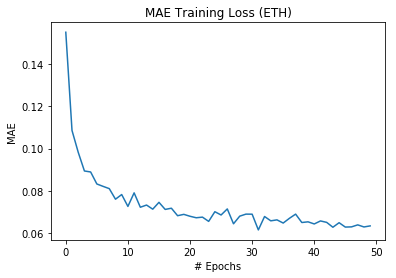

In [23]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(eth_history.epoch,eth_history.history['loss'])
ax1.set_title("MAE Training Loss (ETH)")
ax1.set_xlabel('# Epochs')
ax1.set_ylabel('MAE')

plt.show()

In [ ]:
eth_train_predict = np.squeeze(eth_model.predict(LSTM_training_inputs_np))

In [ ]:
pickle.dump(eth_train_predict,file=open('eth_train_predict.pkl','wb'))

###  ETH Predict

#### On Train Data

In [21]:
eth_train_predict = pickle.load(open('eth_train_predict.pkl','rb'))

In [32]:
eth_close_train=training_set['eth_Close'][window_len-1:-1]
eth_close_pred_train=eth_close*(eth_train_predict+1)

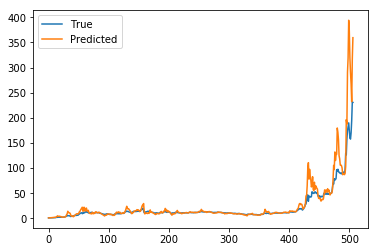

In [44]:
fig,ax1 = plt.subplots(1,1)
x = np.arange(0,eth_close_train.shape[0])
ax1.plot(x,training_set['eth_Close'][window_len:],label='True')
ax1.plot(x,eth_close_pred_train,label='Predicted')
plt.legend()
plt.show()

In [40]:
 ((np.transpose(eth_train_predict)+1) * training_set['eth_Close'].values[:-window_len])

array([   0.9929314 ,    1.0556893 ,    1.12318481,    1.13036831,
          1.18172848,    1.14372391,    1.2575355 ,    1.37742231,
          1.26907219,    1.47076381,    1.5591092 ,    1.57290007,
          1.52377834,    2.00187951,    2.27231685,    2.55271471,
          2.28916111,    2.41953686,    2.47037356,    2.49111635,
          2.41602042,    2.30311668,    2.24648054,    2.44112271,
          2.51817495,    2.57800631,    2.53884022,    2.52833773,
          2.96872984,    3.30046748,    4.27847192,    4.56269221,
          5.79277542,    5.65333067,    5.22492837,    5.33271229,
          4.77066534,    4.34703528,    3.826958  ,    4.44262704,
          4.79533622,    4.57351064,    4.67865196,    5.58132856,
          5.65529112,    6.32666647,    6.1875194 ,    5.87671671,
          6.42247119,    6.48766186,    6.34457252,    7.84538997,
          8.85716207,    9.71894335,   10.92839527,   11.20908654,
         11.60305767,    9.74884525,    9.68912543,   11.91509

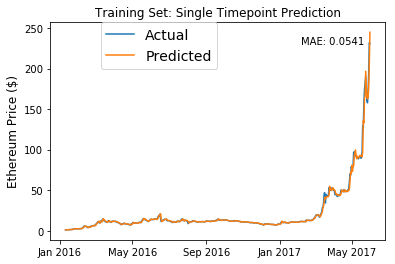

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])

ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')

ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_train_predict)+1) * training_set['eth_Close'].values[:-window_len]), 
         label='Predicted')

ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_train_predict)+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')

plt.show()

(507,)